# Plots for NeurIPS 2025 publication


In [1]:
import matplotlib.pyplot as plt
from nn_compression.experiments import DatabaseManager
import numpy as np
import pandas as pd
import copy
from data_utils.experiments import pareto_front
from matplotlib.axes._axes import Axes # type: ignore
from plots_neurips_style import *
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
import matplotlib as mpl


pareto_cv = lambda df: pareto_front(df, "bitrate", "performance", "over")
#pareto_cv = lambda df: df
pareto_nlp = lambda df: pareto_front(df, "bitrate", "performance", "under")
db_path = "../experiments.db"
methods = ["optq-rd-r", "optq-rd", "optq", "nnc", "rtn"]
plt.rcParams.update({
    "pdf.fonttype": 42,      # Use Type 42 (TrueType)
    "ps.fonttype": 42,
    "font.family": "sans-serif",  # or "serif"
    "font.sans-serif": ["DejaVu Sans"],  # Or another TTF font installed
        'font.size': 14,          # Default text size
    'axes.titlesize': 13,     # Title size
    'axes.labelsize': 13,     # Axis label size
    'xtick.labelsize': 10,    # X-axis tick label size
    'ytick.labelsize': 10,    # Y-axis tick label size
    'legend.fontsize': 10,    # Legend font size
    'figure.titlesize': 13,    # Figure title size
    'axes.grid': True,
    'grid.color': "gray",
    'grid.alpha': 0.3
})

### Data Creation

In [2]:
def make_invisible(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.patch.set_visible(False)  # remove background
    ax.tick_params(left=False, bottom=False)

def keep_newest_rows_optq(df, key_columns, timestamp_column='timestamp'):
    # Split the dataframe into two parts
    optq_rows = df[df['compression_method'] == 'optq']
    other_rows = df[df['compression_method'] != 'optq']
    
    # For optq rows, keep only the newest for each unique combination of key_columns
    if not optq_rows.empty:
        # Sort the dataframe by timestamp in descending order (newest first)
        optq_sorted = optq_rows.sort_values(by=timestamp_column, ascending=False)
        
        # Drop duplicates, keeping the first occurrence (newest due to sorting)
        optq_filtered = optq_sorted.drop_duplicates(subset=key_columns, keep='first')
    else:
        optq_filtered = optq_rows
    
    # Combine the filtered optq rows with the unfiltered other rows
    result = pd.concat([optq_filtered, other_rows], ignore_index=False)
    
    # Optional: sort by the original index to maintain order
    # result = result.sort_index()
    
    return result

def keep_newest_rows(df, key_columns, timestamp_column='timestamp'):
    df_sorted = df.sort_values(by=timestamp_column, ascending=False)
    return df_sorted.drop_duplicates(subset=key_columns, keep='first')

def load_data():
    df = DatabaseManager(db_path).to_df()
    df = df.query("experiment_name != 'dummy'")
    
    df = keep_newest_rows_optq(df, key_columns=["compression_nbins", "compression_method", "network_name", "network_train_dataset", "compression_scan_order_major", "compression_log10_lm"])
    #df = remove_row(df)
    
    # For each row, apply the correct overhead based on the condition
    for idx, row in df.iterrows():
        if row['compression_method'] != 'nnc':
            network = row['network_name']
            
            # Create the correct key for OVERHEADS lookup
            if 'resnet' in network.lower():
                # Combine network_name with network_train_dataset for resnet models
                lookup_key = f"{network}_{row['network_train_dataset']}"
            else:
                # Just use network_name for other models
                lookup_key = network
                
            # Apply the overhead if the key exists
            if lookup_key in OVERHEADS:
                df.at[idx, 'bitrate'] += OVERHEADS[lookup_key]
            else:
                print(f"Warning: No overhead found for key '{lookup_key}'")
    return Results(df)


def query(network_dataset):
    if "resnet" in network_dataset:
        net, ds = network_dataset.split("_")
    elif "pythia" in network_dataset:
        net = network_dataset
        ds = "wikitext"
    else:
        net = network_dataset
        ds = "imagenet"
    return [f"evaluation_dataset == '{ds}' & calibration_dataset == '{ds}' & network_train_dataset == '{ds}' & network_name == '{net}'"]

class Results:
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df
        self.query = []
        self.frozen = []
    
    def freeze(self):
        self.frozen = list(set(self.frozen + self.query))
        return self
    
    def resnet18_cifar10(self):
        self.query += query("resnet18_cifar10")
        return self

    def resnet34_cifar10(self):
        self.query += query("resnet34_cifar10")
        return self

    def resnet50_cifar10(self):
        self.query += query("resnet50_cifar10")
        return self

    def resnet18_imagenet(self):
        self.query += query("resnet18_imagenet")
        return self

    def resnet34_imagenet(self):
        self.query += query("resnet34_imagenet")
        return self

    def resnet50_imagenet(self):
        self.query += query("resnet50_imagenet")
        return self

    def resnet101_imagenet(self):
        self.query += query("resnet101_imagenet")
        return self

    def resnet152_imagenet(self):
        self.query += query("resnet152_imagenet")
        return self

    def vgg16(self):
        self.query += query("vgg16")
        return self

    def mobilenetv3_small(self):
        self.query += query("mobilenetv3_small")
        return self

    def mobilenetv3_large(self):
        self.query += query("mobilenetv3_large")
        return self

    def pythia70m(self):
        self.query += query("pythia-70m")
        return self

    def row(self):
        self.query += ["compression_scan_order_major == 'row'"]
        return self
    
    def col(self):
        self.query += ["compression_scan_order_major == 'col'"]
        return self
    
    def optq(self):
        self.query += ["compression_method == 'optq'"]
        return self

    def optq_rd(self):
        self.query += ["compression_method == 'optq-rd'"]
        return self

    def optq_rd_r(self):
        self.query += ["compression_method == 'optq-rd-r'"]
        return self

    def nnc(self):
        self.query += ["compression_method == 'nnc'"]
        return self

    def rtn(self):
        self.query += ["compression_method == 'rtn'"]
        return self
    
    def b(self, rebuild: bool = True) -> pd.DataFrame:
        query = self.frozen + self.query
        if self.query == []:
            return self.df
        df_queried = self.df.query(" & ".join(query))
        if rebuild:
            self.query = copy.deepcopy(self.frozen)
        return df_queried
    
    def q(self, s):
        return getattr(self, s)()

### Plotting

In [3]:
def save(fig, name):
    path = f"../figures/{name}"
    fig.savefig(path + ".pdf", bbox_inches="tight")
    fig.savefig(path + ".png", bbox_inches="tight")

def determine_interesting_region(net, perc=0.05):
    return (1-perc) * BASELINE_PERF[net], (1+perc/4) * BASELINE_PERF[net]


def threshhold_performance(df, perf):
    is_over = df[df.performance > perf]
    if len(is_over) == 0:
        best_perf = df.performance.argmax()
        return df.iloc[best_perf]
    idx = is_over.bitrate.argmin()
    best_row = is_over.iloc[idx]
    return best_row

def threshhold_performance_per_method(df, perf):
    d = {}
    for n, gp in df.groupby("compression_method"):
        best_row = threshhold_performance(gp, perf)
        d[n]  = best_row.bitrate, best_row.performance
    return d

def remove_row(df):
    # Create a boolean mask for the conditions
    mask = ~((df.compression_method.isin(["optq", "optq-rd-r", "optq-rd"])) & 
            (df.compression_scan_order_major == 'row'))

    # Apply the mask to filter the dataframe
    filtered_df = df[mask]
    return filtered_df
    

import pandas as pd

def network_performance_plot(df , ax: Axes, add_ylabel = True, add_xlabel = True):
    if isinstance(df, Results):
        df = df.b()
    if df.experiment_task.iloc[0] == "cv":
        pareto = pareto_cv
        ylabel = AXIS_LABELS_CV[1]
    else:
        pareto = pareto_nlp 
        ylabel = AXIS_LABELS_NLP[1]
    xlabel = BPW_LABEL
    handles = []
    for method in methods:
        df_grouped = df.query(f"compression_method == '{method}'")
        df_grouped = pareto(df_grouped) 
        handle = ax.plot(df_grouped.bitrate, df_grouped.performance, label=PLOT_LABELS[method], **PLOT_PARAMS_METHODS[method]) # type: ignore
        handles.append(handle[0])

    if add_xlabel:
        ax.set_xlabel(xlabel) 
    if add_ylabel:
        ax.set_ylabel(ylabel)  # type: ignore
    return handles

def human_readable_size(net_name):
    return f"{round(NQUANTISABLE_PARAMS[net_name] / 1e6):d}M"

def add_info(ax, net_name, title_inside: bool = False):
    hline = ax.axhline(
        y=BASELINE_PERF[net_name],
        label="Original",
        **PLOT_PARAMS_METHODS["base_performance"],
    )

    title = f"{NETWORK_LABELS[net_name]} ({human_readable_size(net_name)})"
    if title_inside:
        ax.text(0.5, 0.92, title,
            transform=ax.transAxes,  # Use axes coordinates (0-1 range)
            fontsize=12,
            horizontalalignment='center',
            verticalalignment='center')

        ax.set_ylim(0,0.95)
    else:
        ax.set_title(f"{NETWORK_LABELS[net_name]} ({human_readable_size(net_name)} Params)")
    return hline
    


def add_zoom_inset(ax, x_range, y_range, width="40%", height="40%", loc="lower right", hline=None):
        # Create the inset axes
    axins = inset_axes(ax, width=width, height=height, loc=loc)
    
    # Plot the same data in the inset
    for line in ax.lines:
        axins.plot(line.get_xdata(), line.get_ydata(), 
                  color=line.get_color(), 
                  linestyle=line.get_linestyle(),
                  linewidth=line.get_linewidth(),
                  marker=line.get_marker(),
                  markersize=line.get_markersize() if line.get_markersize() is not None else 6)
    # If a horizontal line handle is provided, draw it in the inset
    if hline is not None:
        # Get the y-value from the horizontal line
        y_value = hline.get_ydata()[0]  # Horizontal lines have the same y value throughout
        
        # Draw the horizontal line with the same properties
        axins.axhline(
            y=y_value,
            color=hline.get_color(),
            linestyle=hline.get_linestyle(),
            linewidth=hline.get_linewidth(),
            alpha=hline.get_alpha() if hline.get_alpha() is not None else 1
        )
    
    # Set the limits of the inset to the specified ranges
    axins.set_xlim(x_range)
    axins.set_ylim(y_range)
    
    # Mark the zoomed region in the main plot
    rect = patches.Rectangle(
        (x_range[0], y_range[0]),
        x_range[1] - x_range[0],
        y_range[1] - y_range[0],
        linewidth=2,
        edgecolor='crimson',
        #edgecolor='dimgray',
        facecolor='none',
        alpha=0.6,
        zorder=1000  # Ensure it's on top
    )
    ax.add_patch(rect)
    
    axins.grid(True, linestyle='--', alpha=0.7)
    axins.tick_params(axis='both', which='major', labelsize=8)
    axins.xaxis.set_ticks_position('top')  # Move the ticks to the top
    axins.xaxis.set_label_position('top')  # Move the label to the top
    
    return axins

 

## Paper plots

Text(0.5, 0.98, 'OPTQ-RD-R')

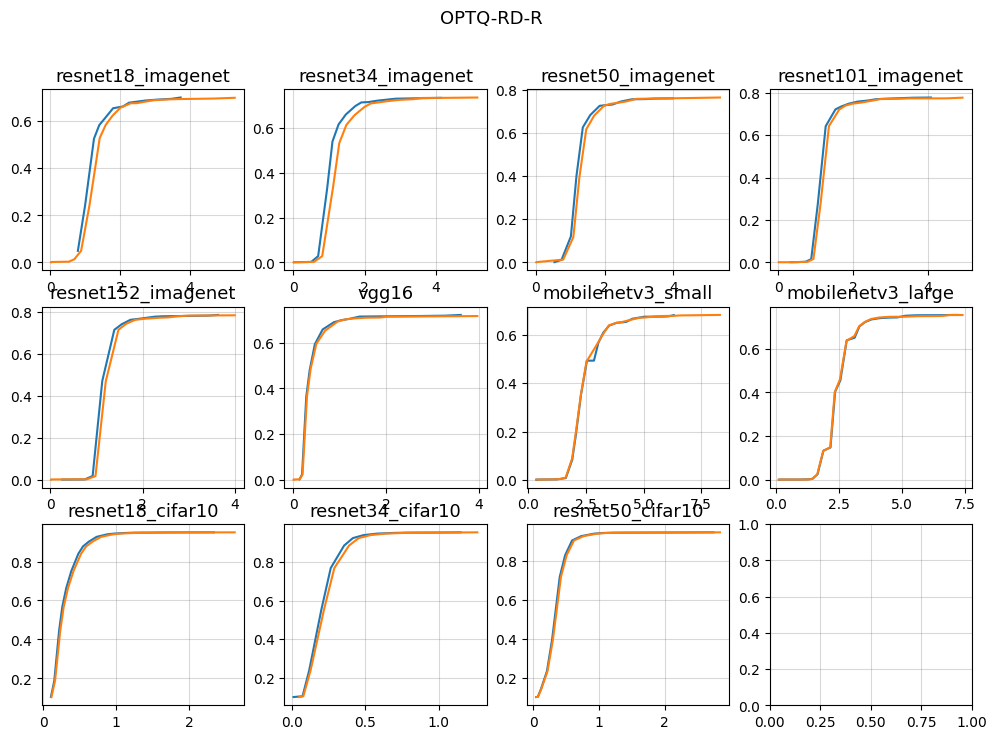

In [4]:
r = load_data()
def rowvscolplot(ax, net):
    row = pareto_cv(r.nnc().row().q(net).b())
    col = pareto_cv(r.nnc().col().q(net).b())
    ax.plot(row.bitrate, row.performance, label="row")
    ax.plot(col.bitrate, col.performance, label="col")
    ax.set_title(net)

fig, axs = plt.subplots(3,4, figsize=(12,8))
axs = axs.flatten()
i = 0
for net in ["resnet18_imagenet", "resnet34_imagenet", "resnet50_imagenet","resnet101_imagenet","resnet152_imagenet", "vgg16", "mobilenetv3_small", "mobilenetv3_large", "resnet18_cifar10", "resnet34_cifar10", "resnet50_cifar10"]:
    rowvscolplot(axs[i], net)
    i+= 1
fig.suptitle("OPTQ-RD-R")

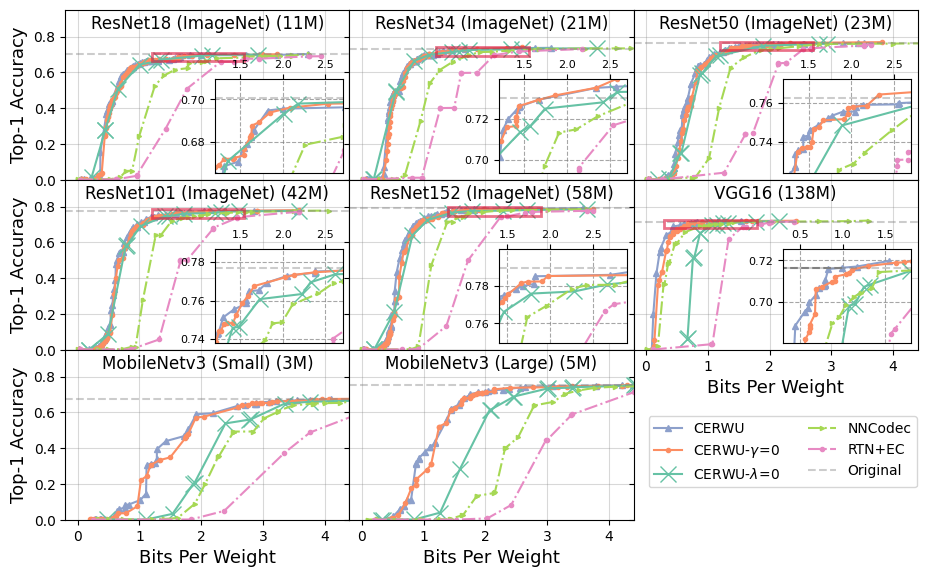

In [5]:
#r = load_data().row().freeze()
#r = load_data().row().freeze()
fig, ax = plt.subplots(3,3, figsize=(11,6), sharex=False, sharey=True) # 9,12
axes = ax.flatten()
for ax in axes:
    ax.set_xlim(-0.2,4.4) # 0,4.2
#
handles = network_performance_plot(r.resnet18_imagenet(), axes[0], add_xlabel=False, add_ylabel=True)
hline0 = add_info(axes[0], "resnet18_imagenet", title_inside=True)
network_performance_plot(r.resnet34_imagenet(), axes[1], add_ylabel=False, add_xlabel=False)
hline1 = add_info(axes[1], "resnet34_imagenet", title_inside=True)
network_performance_plot(r.resnet50_imagenet(), axes[2], add_xlabel=False, add_ylabel=False)
hline2 = add_info(axes[2], "resnet50_imagenet", title_inside=True)
network_performance_plot(r.resnet101_imagenet(), axes[3], add_ylabel=True, add_xlabel=False)
hline3 = add_info(axes[3], "resnet101_imagenet", title_inside=True)
network_performance_plot(r.resnet152_imagenet(), axes[4], add_xlabel=False, add_ylabel=False)
hline4 = add_info(axes[4], "resnet152_imagenet", title_inside=True)
#
network_performance_plot(r.vgg16(), axes[5], add_ylabel=False, add_xlabel=True)
hline5 = add_info(axes[5], "vgg16", title_inside=True)
#
network_performance_plot(r.mobilenetv3_small(), axes[6], add_xlabel=True, add_ylabel=True)
hline6 = add_info(axes[6], "mobilenetv3_small", title_inside=True)
network_performance_plot(r.mobilenetv3_large(), axes[7], add_ylabel=False, add_xlabel=True)
hline7 = add_info(axes[7], "mobilenetv3_large", title_inside=True)
#
add_zoom_inset(axes[0], (1.2, 2.7), determine_interesting_region("resnet18_imagenet"), width="45%", height="55%", hline=hline0) # resnet18
add_zoom_inset(axes[1], (1.2, 2.7), determine_interesting_region("resnet34_imagenet"), width="45%", height="55%", hline=hline1) # resnet34
add_zoom_inset(axes[2], (1.2, 2.7), determine_interesting_region("resnet50_imagenet"), width="45%", height="55%", hline=hline2) # resnet50
add_zoom_inset(axes[3], (1.2, 2.7), determine_interesting_region("resnet101_imagenet"), width="45%", height="55%", hline=hline3) # resnet101
add_zoom_inset(axes[4], (1.4, 2.9), determine_interesting_region("resnet152_imagenet"), width="45%", height="55%", hline=hline4) # resnet152
add_zoom_inset(axes[5], (0.3, 1.8), determine_interesting_region("vgg16"), width="45%", height="55%", hline=hline5) # vgg16


# add_zoom_inset(axes[6], (2.5, 4), determine_interesting_region("mobilenetv3_small"), width="35%", height="40%", hline=hline6) # mobilenetv3_small
# add_zoom_inset(axes[7], (0.3, 1.8), determine_interesting_region("mobilenetv3_large"), width="45%", height="55%", hline=hline7) # mobilenetv3_large
#
#fig.legend(handles=handles + [hline0], loc="lower right", ncol=1, bbox_to_anchor=(0,0.18,0.87,0), frameon=False, fontsize=11)
axes[-1].legend(handles=handles + [hline0], loc="lower center", ncol=2, frameon=True, fontsize=10, bbox_to_anchor=(0.275,0.15,0.5,0))
#axes[-1].grid(visible=None)
#axes[-1].set_xlabel(BPW_LABEL)
#make_invisible(axes[-1])
axes[-1].set_frame_on(False)
axes[-1].set_xticklabels([])
axes[-1].set_xticks([])
axes[-1].grid(None)

#plt.tight_layout(rect=[0, 0, 1, 0.98])  # type: ignore
fig.subplots_adjust(wspace=0, hspace=0, top=0.96)
save(fig, "compression_performance_lines_imagenet_square")

In [6]:
# ss = r.optq_rd_r().resnet18_imagenet().b().query("compression_nbins == 16").sort_values("compression_log10_lm")
# plt.xlim(0,3)
# plt.plot(ss.bitrate, ss.performance, "--.")
# ss[["compression_log10_lm", "performance", "bitrate"]]
# #ss.compression_log10_lm

/var/folders/y_/dfyprtgj10nfjm41ndpn6vxc0000gn/T/ipykernel_43755/2469685760.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.90])  # type: ignore


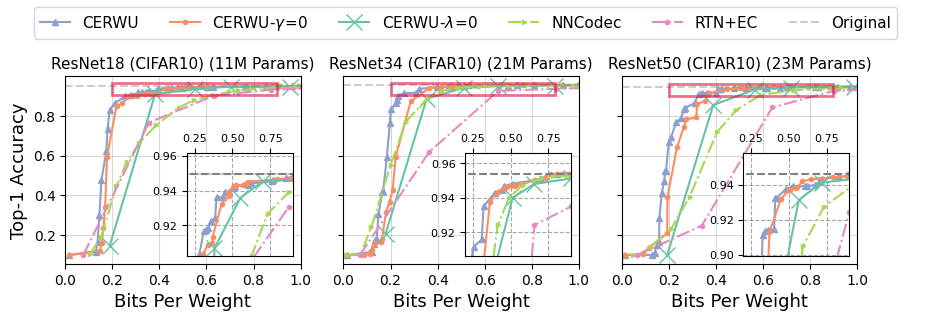

In [21]:
fig, ax = plt.subplots(1,3, figsize=(10,3.3), sharex=True, sharey=True)
axes = ax.flatten()
for ax in axes:
    ax.set_xlim(0,1)

with mpl.rc_context({"legend.fontsize":11, "axes.titlesize": 11}):
    handles = network_performance_plot(r.resnet18_cifar10(), axes[0])
    hline0 = add_info(axes[0], "resnet18_cifar10")
    network_performance_plot(r.resnet34_cifar10(), axes[1], add_ylabel=False)
    add_info(axes[1], "resnet34_cifar10")
    network_performance_plot(r.resnet50_cifar10(), axes[2], add_ylabel=False)
    add_info(axes[2], "resnet50_cifar10")
    #
    add_zoom_inset(axes[0], (0.2, 0.9), determine_interesting_region("resnet18_cifar10"), width="45%", height="55%", hline=hline0) # resnet18
    add_zoom_inset(axes[1], (0.2, 0.9), determine_interesting_region("resnet34_cifar10"), width="45%", height="55%", hline=hline1) # resnet34
    add_zoom_inset(axes[2], (0.2, 0.9), determine_interesting_region("resnet50_cifar10"), width="45%", height="55%", hline=hline2) # resnet50
    #
    fig.legend(handles=handles + [hline0], loc="upper center", ncol=len(handles) + 1)
    plt.tight_layout(rect=[0, 0, 0.9, 0.90])  # type: ignore
    save(fig, "compression_performance_lines_cifar10")

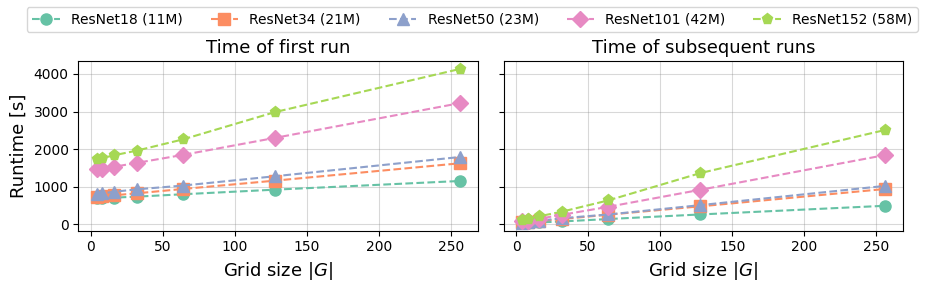

In [28]:
distinct_colors = [c0,c1,c2,c3,c4] 
markers = ['o', 's', '^', 'D', 'p']

networks = ["resnet18_imagenet", "resnet34_imagenet", "resnet50_imagenet", "resnet101_imagenet", "resnet152_imagenet"]
def runtime_plot(ax, include_hessian_calc, include_ylabel = False):
    # Define distinct colors for each network

    # Sort networks by parameter count for consistent color assignment
    networks_by_size = sorted(networks, key=lambda x: NQUANTISABLE_PARAMS[x])
    handles = []

    for i, net in enumerate(networks):
        # Assign colors based on parameter count (smallest = red, largest = orange)
        color_idx = networks_by_size.index(net)

        if include_hessian_calc:
            total_times = np.array(RUN_TIMES_RESNET[net]["times"]) + HESSIAN_CALC_TIMES[net]
        else:
            total_times = np.array(RUN_TIMES_RESNET[net]["times"]) 
        
        handle = ax.plot(RUN_TIMES_RESNET[net]["bins"], 
                total_times,
                linestyle='--', 
                marker=markers[i],
                color=distinct_colors[color_idx],
                markersize=8,
                label=f"{NETWORK_LABELS[net].split(" ")[0]} ({human_readable_size(net)})")

        handles.append(handle[0])
    if include_hessian_calc:
        ax.set_title("Time of first run")
    else:
        ax.set_title("Time of subsequent runs")
    ax.set_xlabel(r"Grid size $|G|$")
    if include_ylabel:
        ax.set_ylabel("Runtime [s]")
    return handles

fig, ax = plt.subplots(1,2, figsize=(10,3), sharex=True, sharey=True)
handles =  runtime_plot(ax[0], True, True)
runtime_plot(ax[1], False)
fig.legend(handles=handles, ncol=len(networks), loc="upper center")
plt.tight_layout(rect=[0,0,0.935,0.95])
save(fig, "runtimes_compression")

In [9]:
for net in ["resnet18_imagenet", "resnet34_imagenet", "resnet50_imagenet","resnet101_imagenet","resnet152_imagenet", "vgg16", "mobilenetv3_small", "mobilenetv3_large", "resnet18_cifar10", "resnet34_cifar10", "resnet50_cifar10"]:
    subset = r.q(net).b()
    tpf = threshhold_performance_per_method(subset, 0.985 * BASELINE_PERF[net])
    print(net, tpf)
    

resnet18_imagenet {'nnc': (3.0551049385900058, 0.6915625), 'optq': (2.0095420431583952, 0.6933125), 'optq-rd': (1.850791544573267, 0.693875), 'optq-rd-r': (1.8224816081862538, 0.6948125), 'rtn': (3.9369092889808077, 0.689875)}
resnet34_imagenet {'nnc': (2.3605043679489146, 0.7213125), 'optq': (1.7428673383394346, 0.7250625), 'optq-rd': (1.4067135807158542, 0.721), 'optq-rd-r': (1.3117232574881752, 0.7200625), 'rtn': (3.564683208916661, 0.730125)}
resnet50_imagenet {'nnc': (2.797705145941285, 0.756375), 'optq': (2.800193907094093, 0.7591875), 'optq-rd': (1.91892403180968, 0.75175), 'optq-rd-r': (1.7323265364947862, 0.7523125), 'rtn': (3.535943099107023, 0.75325)}
resnet101_imagenet {'nnc': (2.6023713842749077, 0.769375), 'optq': (2.3249430803648035, 0.7695625), 'optq-rd': (1.6650408998137445, 0.767625), 'optq-rd-r': (1.7179217929026984, 0.7654375), 'rtn': (3.577043193919592, 0.771125)}
resnet152_imagenet {'nnc': (2.257763916034216, 0.77825), 'optq': (2.6701677956270515, 0.7805625), 'opt

{'resnet50_cifar10': {'nnc': (0.9291628112009127, 0.9401), 'optq': (0.7177526364185246, 0.9413), 'optq-rd': (0.5093704070550543, 0.9371), 'optq-rd-r': (0.4793329062636663, 0.9377), 'rtn': (1.3189217179867803, 0.9426)}, 'resnet34_cifar10': {'nnc': (0.5803271199655615, 0.9476), 'optq': (0.6558856897162034, 0.948), 'optq-rd': (0.4594537751711192, 0.9459), 'optq-rd-r': (0.44614883103745734, 0.9447), 'rtn': (1.2935374121913181, 0.9481)}, 'resnet18_cifar10': {'nnc': (0.9712639722876987, 0.9434), 'optq': (0.7033212219623507, 0.9455), 'optq-rd': (0.5071650435860633, 0.9427), 'optq-rd-r': (0.49563395035928476, 0.9413), 'rtn': (1.2716882800780793, 0.9443)}, 'mobilenetv3_large': {'nnc': (4.513224709608662, 0.7465625), 'optq': (4.413360853984791, 0.7506875), 'optq-rd': (3.3962341783675125, 0.7458125), 'optq-rd-r': (3.0984784415128734, 0.74575), 'rtn': (4.42993962584969, 0.71675)}, 'mobilenetv3_small': {'nnc': (4.8236512908309175, 0.6700625), 'optq': (4.815691477548707, 0.6716875), 'optq-rd': (3.83

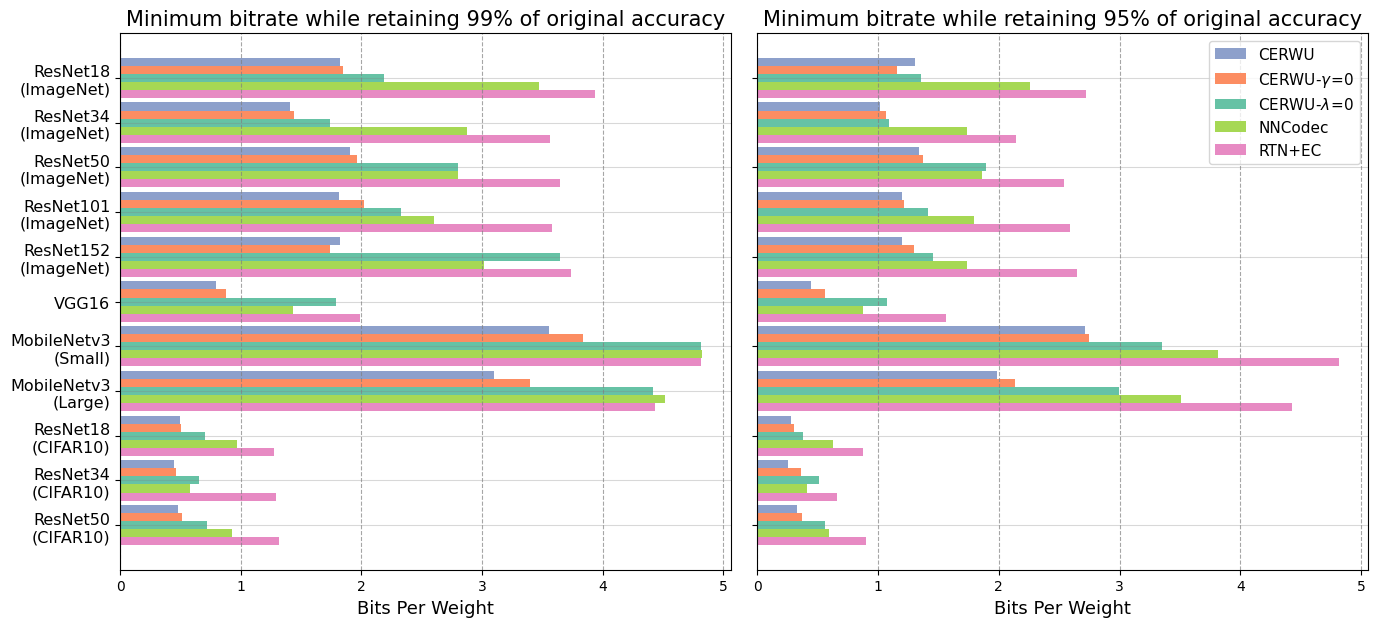

In [10]:
def barplot(ax, perf, include_info=True, title=None):
    # Store results in a dictionary
    results = {}
    networks = ["resnet18_imagenet", "resnet34_imagenet", "resnet50_imagenet",
            "resnet101_imagenet", "resnet152_imagenet", "vgg16", 
            "mobilenetv3_small", "mobilenetv3_large", 
            "resnet18_cifar10", "resnet34_cifar10", "resnet50_cifar10"]
    networks = networks[::-1]

    for net in networks:
        subset = r.q(net).b()
        results[net] = threshhold_performance_per_method(subset, BASELINE_PERF[net] * perf)

    with mpl.rc_context({"legend.fontsize":11, "axes.titlesize": 15, "ytick.labelsize": 14
                        }):
        # Create a figure and axis


        # Plot bars for each method
        bar_width = 0.18
        for i, method in enumerate(methods):
            # Extract bitrates for this method
            bitrates = [results[net][method][0] for net in networks]
            
            # Plot the bars with offset positions
            pos = np.arange(len(networks)) + ((len(methods) - 1 - i) - len(methods)/2 + 0.5) * bar_width
            ax.barh(pos, bitrates, height=bar_width, label=PLOT_LABELS[method], color=PLOT_PARAMS_METHODS[method]["color"])

        # Customize the plot
        if include_info:
            ax.set_yticks(np.arange(len(networks)))
            ax.set_yticklabels(["\n".join(NETWORK_LABELS[net].split(" ")) for net in networks], fontsize=11.5)
        else:
            ax.set_yticklabels([])
            ax.legend()
        if title:
            ax.set_title(title)
        ax.set_xlabel(BPW_LABEL)
        ax.grid(axis='x', linestyle='--', alpha=0.7)
    print(results)

fig, ax = plt.subplots(1,2,figsize=(14, 6.5))
#barplot(ax[0], 0.95)
barplot(ax[0], 0.99, True, "Minimum bitrate while retaining 99% of original accuracy")
barplot(ax[1], 0.95, False,"Minimum bitrate while retaining 95% of original accuracy")

fig.tight_layout()
save(fig, "compression_performance_barplot")

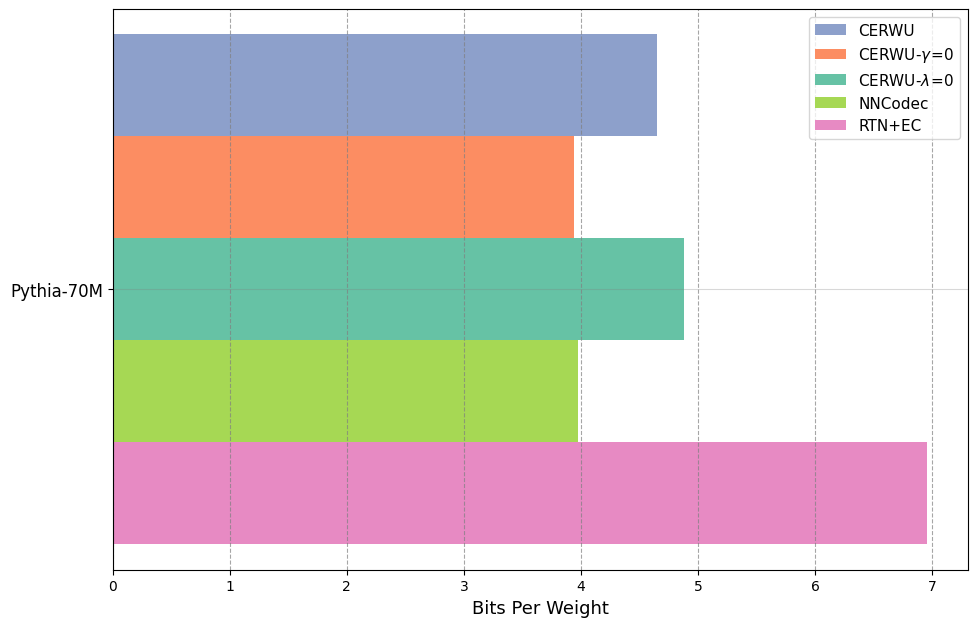

In [11]:
# Store results in a dictionary
results = {}
networks = ["pythia70m"]
networks = networks[::-1]

for net in networks:
    subset = r.q(net).b()
    subset = subset.copy()
    subset.performance = subset.performance * -1.0
    results[net] = threshhold_performance_per_method(subset, -BASELINE_PERF[net] * 2)

with mpl.rc_context({"legend.fontsize":11, "axes.titlesize": 11, "ytick.labelsize": 12
                     }):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6.5))

    # Plot bars for each method
    bar_width = 0.18
    for i, method in enumerate(methods):
        # Extract bitrates for this method
        bitrates = [results[net][method][0] for net in networks]
        
        # Plot the bars with offset positions
        pos = np.arange(len(networks)) + ((len(methods) - 1 - i) - len(methods)/2 + 0.5) * bar_width
        ax.barh(pos, bitrates, height=bar_width, label=PLOT_LABELS[method], color=PLOT_PARAMS_METHODS[method]["color"])

    # Customize the plot
    ax.set_yticks(np.arange(len(networks)))
    ax.set_yticklabels(["\n".join(NETWORK_LABELS[net].split(" ")) for net in networks])
    ax.set_xlabel(BPW_LABEL)
    ax.legend()
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    #save(fig, "compression_performance_barplot")

    plt.tight_layout()
    plt.show()

In [12]:
nbinsl = list(r.pythia70m().b().compression_nbins.unique())
nbinsl.sort()
nbinsl

[4, 16, 128, 256, 352, 512, 768, 1024, 2048]

/var/folders/y_/dfyprtgj10nfjm41ndpn6vxc0000gn/T/ipykernel_43755/2681017746.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**5)


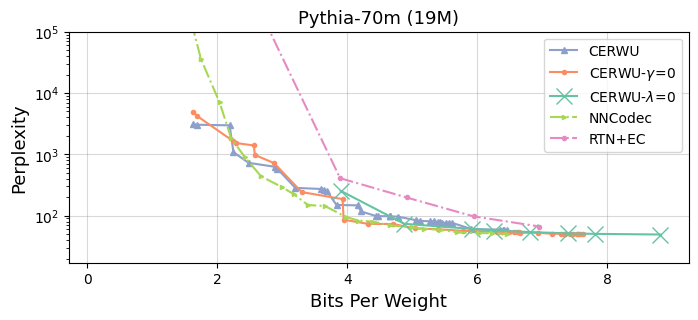

In [13]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

handles = network_performance_plot(r.pythia70m(), ax)
ax.set_title(f"Pythia-70m ({human_readable_size('pythia-70m')})")
ax.set_yscale("log")
ax.set_ylim(0, 10**5)
plt.legend()
save(fig, "pythia70m")


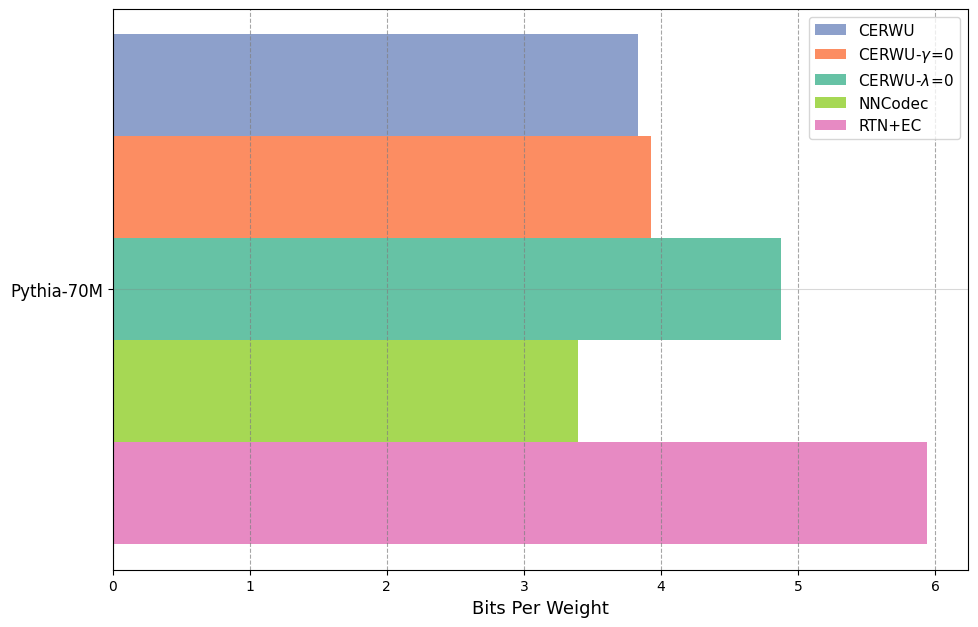

In [14]:
# Store results in a dictionary
results = {}
networks = ["pythia70m"]
networks = networks[::-1]

for net in networks:
    subset = r.q(net).b()
    subset = subset.copy()
    subset.performance = subset.performance * -1.0
    results[net] = threshhold_performance_per_method(subset, -BASELINE_PERF[net] * 4)

with mpl.rc_context({"legend.fontsize":11, "axes.titlesize": 11, "ytick.labelsize": 12
                     }):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6.5))

    # Plot bars for each method
    bar_width = 0.18
    for i, method in enumerate(methods):
        # Extract bitrates for this method
        bitrates = [results[net][method][0] for net in networks]
        
        # Plot the bars with offset positions
        pos = np.arange(len(networks)) + ((len(methods) - 1 - i) - len(methods)/2 + 0.5) * bar_width
        ax.barh(pos, bitrates, height=bar_width, label=PLOT_LABELS[method], color=PLOT_PARAMS_METHODS[method]["color"])

    # Customize the plot
    ax.set_yticks(np.arange(len(networks)))
    ax.set_yticklabels(["\n".join(NETWORK_LABELS[net].split(" ")) for net in networks])
    ax.set_xlabel(BPW_LABEL)
    ax.legend()
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    #save(fig, "compression_performance_barplot")

    plt.tight_layout()
    plt.show()